In [1]:
#################### 这个是最终得到的关于城市的 rank-sc ###############################
#关于文档的一个数据分类
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
import numpy as np
#import csv
import math
from pandas import Series,DataFrame
from matplotlib.ticker import  MultipleLocator
import pylab as pl   #画图用
from sklearn import svm
from sklearn import linear_model

In [2]:
a = np.arange(2000,2018)
pop = [str(i)+'Pop' for i in a]
investment = [str(i)+'总投资金额(M)' for i in a]
inv_times = [str(i)+'总投资次数' for i in a]
gdp = [str(i)+'GDP' for i in a]

In [3]:
data =pd.read_excel('E:/vcdata/data/ALL_Intersection.xlsx')  # 读取训练数据
city=data['City'].drop_duplicates().values
City=data['city'].drop_duplicates().values

Data = pd.read_excel('E:/vcdata/data/ALL_investment.xlsx')
city2 = Data['city'].drop_duplicates().values
# data2 = pd.read_excel('E:/文档系列/python 系列/TheData/merge/ALL(1991-2017仅插值).xlsx')
city3 = data['City'].values###得到城市
cityUN=list(set(city3).intersection(set(city2))) ###得到两个城市的交集

In [4]:
len(cityUN)###254

254

In [5]:
from scipy.optimize import leastsq  ##引入最小二乘法算法
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y

plt.rcParams['font.sans-serif']=['Simhei']     #解决中文显示问题，目前只知道黑体可行
plt.rcParams['axes.unicode_minus']=False       #解决负数坐标显示问题

In [6]:
##### 求残差 logy-log（kx+b）
def GuiJI(data,xl,yl,i,xname,yname):
    ###xl,yl：列名的list,xname,yname：列名,i:年份
    city=data['City'].drop_duplicates().values
    province=data['province'].values###得到省
    r=[]  ###标度率
    ###保存取完log后大于0的值
    p=[]
    g=[]
    ###保存所有的log值，小于0的记录为-1
    p2=[]
    g2=[]
    ###取列值的log
    XI=data[xl[i]]
    YI=data[yl[i]]
    xi=np.log(XI)
    yi=np.log(YI)
    XII=xi.fillna(np.infty) ###将空值置为inf
    YII=yi.fillna(np.infty)
    ###判断是否大于0
    City=[]###保存log值大于0的城市名
    pro=[]###保存log值大于0的省名
    for mm in range(len(XII)):
        if XII[mm]==-float('Inf') or XII[mm]==float('Inf') or YII[mm]==-float('Inf') or YII[mm]==float('Inf'):
            continue
        else:
            p.append(XII[mm])
            g.append(YII[mm])
#             p2.append(XII[mm])
#             g2.append(YII[mm])
            City.append(city[mm])
            pro.append(province[mm])
                           
    #k,b的初始值，可以任意设定,经过几次试验，发现p0的值会影响cost的值：Para[1]
    p0=[1,10]
    Xi=np.array(p)
    Yi=np.array(g)
    #把error函数中除了p0以外的参数打包到args中(使用要求)
    Para=leastsq(error,p0,args=(Xi,Yi))## 三个参数：误差函数、函数参数列表、数据点
    #读取结果
    k,b=Para[0]
    ###将标度率写入r中
    r.append(k) 
    y = [k*x+b for x in p]
    ###得到残差
    sc=[g[v]-y[v] for v in range(len(g))]
    
    ###计算频率分布
    maxsc=max(sc)
    minsc=min(sc)
    Paragraph_len=(maxsc-minsc)/10
    fresc=[]###频率
    xvalue=[] ###坐标所在数段
    for i in range(10):
        num=0
        psc=minsc+Paragraph_len*i ###左坐标
        rpsc=psc+Paragraph_len    ###右坐标
        for scj in sc:
            if scj>=psc and scj<rpsc:
                num=num+1
        fresc.append(num/len(City))
        xvalue.append((psc+rpsc)/2)
        
    ###按照sc的值进行排序
    scdic = list(zip(sc,City))
    scSort = sorted( scdic)###残差城市排序
    
#     prodic = dict(zip(pro,sc))
#     proSort = sorted( prodic.items(),key = lambda x:x[1],reverse = True)###省作为item会有很多省北过滤掉
    prodic = list(zip(sc,pro))
    proSort = sorted( prodic)
    return(r,City,p,g,y,sc,fresc,xvalue,scSort,k,b,proSort)

In [7]:
def getCity(s):
    a=list(s.split('|'))
    return(a[1])
data['province']=data.city.map(getCity)
province=data['province'].drop_duplicates().values###得到省
c=len(province)###一级产业数量
a=list(sns.color_palette("hls", c))
yj_color=dict(zip(province,a))

In [8]:
Eprovince = ['Hainan','Henan','Shanghai','Jiangxi','Guangdong','Shandong','Ningxia','Shanxi','Yunnan','Liaoning',
             'Zhejiang','Neimenggu','Xinjiang','Sichuan','Heilongjiang','Hebei','Anhui','Gansu','Beijing','Guangxi',
             'Hubei','Jiangsu','Fujian','Jilin','Shanxi','Tianjin','Hunan','Xizang','Qinghai','Chongqing','Guizhou']
yj_colorE = dict(zip(Eprovince,a))

In [9]:
######### GDP #############
######################## GDP ########################
###计算相关年份的数据
year=2015
yearvalue=year-2000
sami_GDP0=GuiJI(data,pop,gdp,yearvalue,'pop','GDP')

###城市按照残差排名图
dicsc0=sami_GDP0[8]
scname0=[dicsc0[x][1] for x in range(len(dicsc0))]###城市名
prosc0=sami_GDP0[11]###残差
proname0=[prosc0[x][1] for x in range(len(prosc0))]

x0=np.arange(1,212)
y0=[dicsc0[x][0] for x in range(len(dicsc0))]

In [10]:
################### amount ############################
###计算相关年份的数据
sami_investment0=GuiJI(data,pop,investment,yearvalue,'pop','investment')
###城市按照残差排名图
dicscM0=sami_investment0[8]
scnameM0=[dicscM0[x][1] for x in range(len(dicscM0))]
proscM0=sami_investment0[11]
pronameM0=[proscM0[x][1] for x in range(len(proscM0))]

xM0=np.arange(1,len(scnameM0)+1)
yM0=[dicscM0[x][0] for x in range(len(dicscM0))]

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


In [11]:
#################### times ############################
###计算相关年份的数据
sami_times0=GuiJI(data,pop,inv_times,yearvalue,'pop','times')

###城市按照残差排名图
dicscT0=sami_times0[8]
scnameT0=[dicscT0[x][1] for x in range(len(dicscT0))]
proscT0=sami_times0[11]
pronameT0=[proscT0[x][1] for x in range(len(proscT0))]

xT0=np.arange(1,len(scnameT0)+1)
yT0=[dicscT0[x][0] for x in range(len(dicscT0))]

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


In [12]:
len(proname0),len(scname0)

(275, 275)

In [13]:
### 删选出来又投资的城市，投资次数为1的城市将其残差记为最小值。
sc_GDP0=[] ###保存含有投资的城市的GDP
sc_times0=[] ###保存旱藕投资的城市的投资次数，讲次数为1的残差填充为最小值
for c1 in scnameM0:
    for c2 in range(len(scname0)):
        if scname0[c2] == c1:
            sc_GDP0.append(y0[c2])
### 得到投资次数的残差数据
for c1 in scnameM0:
    for c2 in range(len(scnameT0)):
        if scnameT0[c2] == c1:
            sc_times0.append(yT0[c2])

In [14]:
#### 按照残差对GDP进行排序, 不可以使用字典，会过滤掉一些重复数据
prodic_GDP0 = zip(sc_GDP0,pronameM0)###得到省份sc，对其排序
city_GDP0 = zip(sc_GDP0,scnameM0)###得到省份sc，对其排序
proSort_GDP0 = sorted( prodic_GDP0,reverse = True)
citySort_GDP0 = sorted( city_GDP0,reverse = True)

#### 按照残差对投资金额进行排序
prodic_amount0 = zip(yM0,pronameM0)###得到省份sc，对其排序
city_amount0 = zip(yM0,scnameM0)###得到省份sc，对其排序
proSort_amount0 = sorted( prodic_amount0,reverse = True)
citySort_amount0 = sorted( city_amount0,reverse = True)

#### 按照残差对投资次数进行排序
prodic_times0 = zip(sc_times0,pronameM0)###得到省份sc，对其排序
city_times0 = zip(sc_times0,scnameM0)###得到省份sc，对其排序
proSort_times0 = sorted( prodic_times0,reverse = True)
citySort_times0 = sorted( city_times0,reverse = True)

In [15]:
def pic_rank_residual(proSort,citySort,name1,name2,yj_color,num1,num2):###num为所加关于省的颜色条的省的数量
    proName = [proSort[x][1] for x in range(len(proSort))] ###省名
    cityName = [citySort[x][1] for x in range(len(citySort))] ###城市名
    citySC = [citySort[x][0] for x in range(len(citySort))] ###城市sc
#     plt.figure(figsize=(9,6))
    font2 = {'family' : 'Arial',
        'weight' : 'normal',
        'size' : 18,
        }###设置横纵坐标的字体格式
    plt.xlabel(name1,font2)
    plt.ylabel(r'$\xi$'+name2,font2)
    plt.tick_params(labelsize=18) #刻度字体大小13
    plt.ylim(-5,4)
    ### GDP残差分布情况
    xM = np.arange(1,len(citySC)+1)
    dicPIN = {'北京': 'Beijing', '上海': 'Shanghai', '广州': 'Guangzhou', '深圳': 'Shenzhen', '重庆': 'Chongqing'}
    nm = [-1,-2,-3,-4]
    nmi = 0
    nu2 = 1
    nu3=1
#     for nu in range(num1,num2):###添加省的颜色段
#         plt.barh(y = -1.2,width=10,color=a[nu],left=-8+10*nu2)
#         plt.text(-8+10*nu2,-2.5,Eprovince[nu],size=16, rotation=90.)
#         nu2+=1
    for nu in range(num1,num2):###添加省的颜色段
        plt.bar(x = 5,width=5,bottom = -5.25+0.42*nu2,height=0.42,color=a[nu])
        plt.text(10,-5.2+0.42*nu2,Eprovince[nu],size=18)
        nu2+=1
    for cc in range(len(xM)):
        plt.bar(xM[cc],citySC[cc],color=yj_color[proName[cc]])
        if cityName[cc]=='北京' or cityName[cc]=='上海' or cityName[cc]=='广州' or cityName[cc]=='深圳' or cityName[cc]=='重庆':
#             print(cc)
            
            if cc==23:
                plt.text(xM[cc]+5,1.4, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc==65:
                plt.text(xM[cc],1.2, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc==7:
                plt.text(xM[cc]+5,1.3, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc == 100:
                plt.text(xM[cc]+5,-1, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc == 117:
                plt.text(xM[cc]-5,-1.5, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc==125:
                plt.text(xM[cc]-5,-2, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc==136:
                plt.text(xM[cc]-22,0.1, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc==86:
                plt.text(xM[cc],0.1, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc==74:
                plt.text(xM[cc],0.7, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc==104:
                plt.text(xM[cc]-5,-2, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc==98:
                plt.text(xM[cc]-5,0.3, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            elif cc==122:
                plt.text(xM[cc]-7,-2, dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
            else:                
                plt.text(xM[cc],citySC[cc], dicPIN[cityName[cc]]+'('+'{})'.format(xM[cc]),size=18)
        


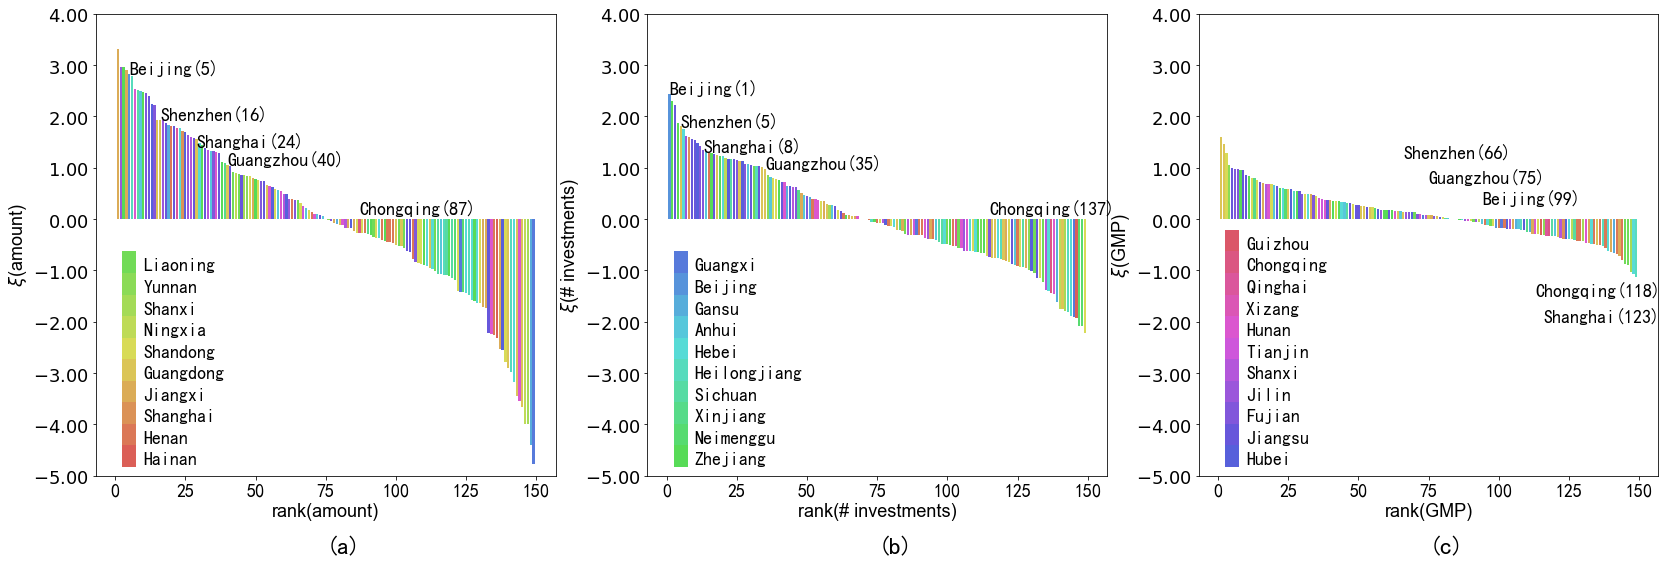

In [22]:
### 投资金额 的 rank-resdual plt.savefig('C:\\Users\\lu\\Desktop\\标度律\\2_times.png')#保存图片
dicPIN = {'北京': 'beijing', '上海': 'shanghai', '广州': 'guangzhou', '深圳': 'shenzhen', '重庆': 'chongqing'}

from matplotlib.ticker import FuncFormatter   ### 今天的主角
def formatnum(x, pos):
    return '$%.2f$' % x
fig = plt.figure(figsize=(28,8.5))
ax1 = fig.add_subplot(131)
formatter = FuncFormatter(formatnum)
ax1.yaxis.set_major_formatter(formatter)
pic_rank_residual(proSort_amount0,citySort_amount0,'rank(amount)','(amount)',yj_color,0,10)
# plt.text(-35,4.1,'(a)',fontsize=24)
plt.text(75,-6.5,'(a)',fontsize=24)

ax2 = fig.add_subplot(132)
ax2.yaxis.set_major_formatter(formatter)
pic_rank_residual(proSort_times0,citySort_times0,'rank(# investments)','(# investments)',yj_color,10,20)
# plt.text(-35,4.1,'(b)',fontsize=24)
plt.text(75,-6.5,'(b)',fontsize=24)

ax3 = fig.add_subplot(133)
ax3.yaxis.set_major_formatter(formatter)
pic_rank_residual(proSort_GDP0,citySort_GDP0,'rank(GMP)','(GMP)',yj_color,20,len(a))
# plt.text(-35,4.1,'(c)',fontsize=24)
plt.text(75,-6.5,'(c)',fontsize=24)
# plt.savefig('C:\\Users\\lu\\Desktop\\标度律\\3_cityrank.png')#保存图片
# plt.tight_layout()
# plt.savefig('E:/vcdata/pic/picSC/Fig2_def.pdf', bbox_inches='tight')
# plt.savefig('E:/0论文/SCA/Fig2_f.pdf', bbox_inches='tight')
plt.savefig('E:/0论文/2picture/3_2.png',dpi=500, bbox_inches='tight')

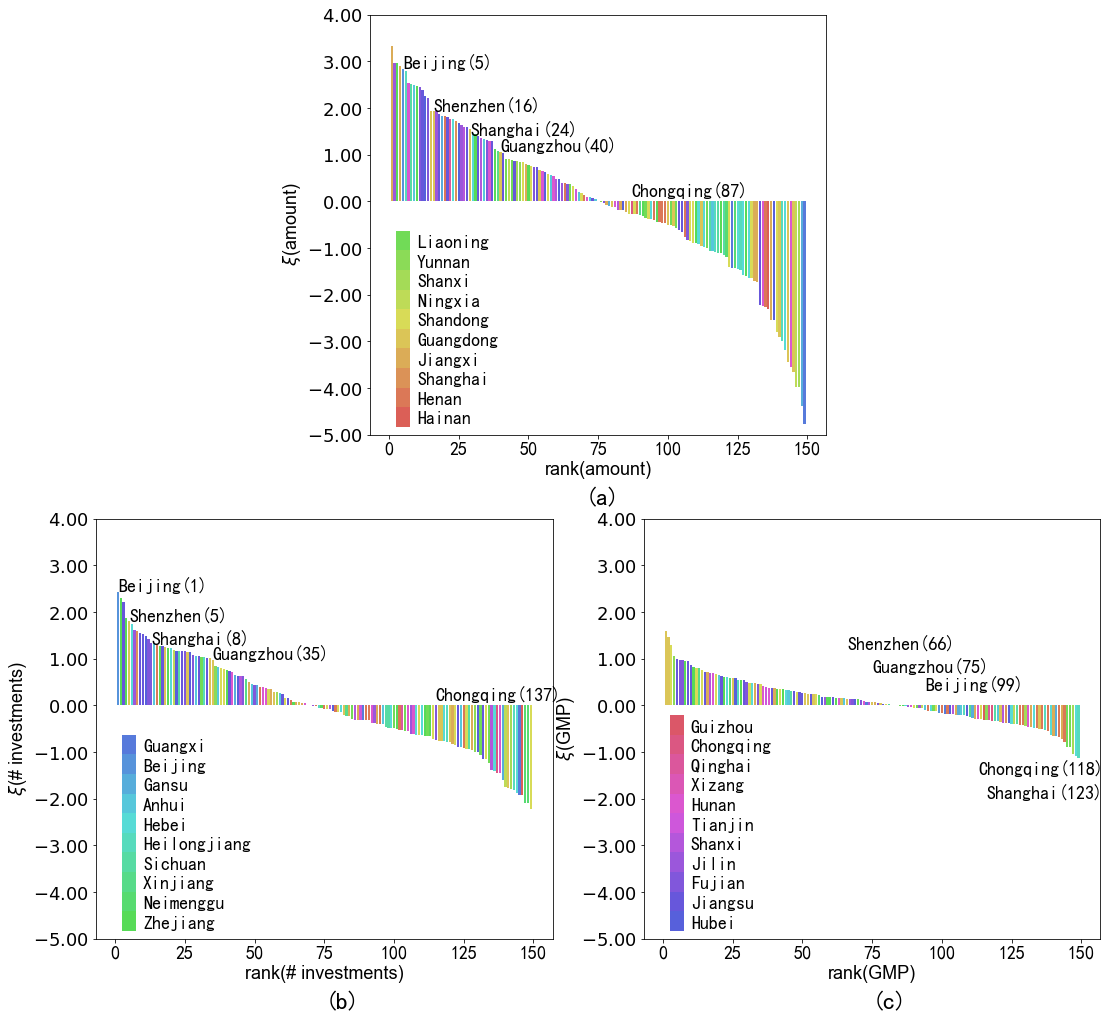

In [25]:
### 投资金额 的 rank-resdual plt.savefig('C:\\Users\\lu\\Desktop\\标度律\\2_times.png')#保存图片
dicPIN = {'北京': 'beijing', '上海': 'shanghai', '广州': 'guangzhou', '深圳': 'shenzhen', '重庆': 'chongqing'}

from matplotlib.ticker import FuncFormatter   ### 今天的主角
def formatnum(x, pos):
    return '$%.2f$' % x
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,17))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, 1:3])
formatter = FuncFormatter(formatnum)
ax1.yaxis.set_major_formatter(formatter)
pic_rank_residual(proSort_amount0,citySort_amount0,'rank(amount)','(amount)',yj_color,0,10)
# plt.text(-35,4.1,'(a)',fontsize=18)
plt.text(70,-6.5,'(a)',fontsize=24)

ax2 = plt.subplot(gs[1, :2], )
ax2.yaxis.set_major_formatter(formatter)
pic_rank_residual(proSort_times0,citySort_times0,'rank(# investments)','(# investments)',yj_color,10,20)
# plt.text(-35,4.1,'(b)',fontsize=18)
plt.text(75,-6.5,'(b)',fontsize=24)

ax3 = plt.subplot(gs[1, 2:])
ax3.yaxis.set_major_formatter(formatter)
pic_rank_residual(proSort_GDP0,citySort_GDP0,'rank(GMP)','(GMP)',yj_color,20,len(a))
# plt.text(-35,4.1,'(c)',fontsize=18)
plt.text(75,-6.5,'(c)',fontsize=24)
# plt.savefig('E:/0论文/SCA/Fig2_f.pdf', bbox_inches='tight')
plt.savefig('E:/0论文/2picture/3_2b.png',dpi=500, bbox_inches='tight')